In [1]:
# Necessary libraries for data manipulation, plotting, molecular dynamics analysis, and order parameter constants.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import opc
import MDAnalysis as mda

class OrderParameters:
    def __init__(self, u, atomlists, resname, selection):
        """Constructor for the OrderParameters class.
        
        Parameters:
        - u: MDAnalysis universe object containing the trajectory and topology information.
        - atomlists: List of atoms for which the order parameter is to be computed.
        - resname: Name of the residue (lipid type).
        - selection: Selection string to filter specific molecules from the universe.
        """
        
        self.u = u
        self.atomlists = atomlists
        self.resname = resname
        self.selection = selection
        
        # Process the provided atom lists to extract relevant atom information.
        self.C_numbers, self.Cs, self.Hs_f, self.repeat = self.process_atom_lists()

    def process_atom_lists(self):
        """Processes the atom list to determine carbon numbers, carbon atom names, hydrogen atom names, and repetition counts."""
        
        C_numbers = []  # List to store carbon numbers
        Cs = []  # List to store carbon atom names
        Hs = []  # List to store hydrogen atom names associated with each carbon
        repeat = []  # List to store how many times each hydrogen atom appears
        
        for atoms in self.atomlists:
            C_number = atoms[0][2:]  # Extract carbon number from atom name
            C_numbers.append(int(C_number))
            Cs.append(atoms[0])  # Store carbon atom name
            Hs.append(atoms[1:])  # Store hydrogen atom names
            repeat.append(len(atoms) - 1)  # Count of hydrogen atoms per center carbon atom
        
        # Flatten the list of hydrogen atoms
        Hs_f = [item for sublist in Hs for item in sublist]
        
        # Check if the total repetitions match the number of hydrogen atoms
        assert int(np.sum(repeat)) == len(Hs_f), "Mismatch in repeats"
        return C_numbers, Cs, Hs_f, repeat

    def compute_OP(self):
        """Compute order parameter for each frame in the trajectory for selected molecules."""
        
        # Select the molecules that match the selection criteria.
        all_molecules = self.u.select_atoms(self.selection, updating=True)
        output = []
        total_frames = len(self.u.trajectory)

#         for ts in self.u.trajectory:  # Iterate through each frame of the trajectory
        for idx, ts in enumerate(self.u.trajectory):  # Iterate through each frame of the trajectory
            print(f"Processing frame {idx + 1} of {total_frames} ...")
            valid_indices_group1 = []  # List to store indices of carbon atoms
            valid_indices_group2 = []  # List to store indices of hydrogen atoms
            
            for molecule in all_molecules.residues:
                atoms_in_molecule = molecule.atoms
                # Check if the molecule contains all atoms of interest
                if all(atom.index in all_molecules.indices for atom in atoms_in_molecule):
                    valid_indices_group1.extend(molecule.atoms.select_atoms("name " + " ".join(self.Cs)).indices)
                    valid_indices_group2.extend(molecule.atoms.select_atoms("name " + " ".join(self.Hs_f)).indices)
            
            # Create atom groups based on the valid indices
            group1 = self.u.atoms[valid_indices_group1]
            group2 = self.u.atoms[valid_indices_group2]

            natoms = len(self.Cs)  # Count of center atoms
            nmols = int(len(group1.positions) / natoms)  # Count of molecules
            repeats = self.repeat * nmols  # Calculate repetitions for this frame

            # Calculate cosine of the angle between molecular segment and bilayer normal (z-axis)
            p1 = np.repeat(group1.positions, repeats, axis=0)  # Repeat carbon atom positions
            p2 = group2.positions  # Hydrogen atom positions
            dp = p2 - p1  # Difference in positions
            norm = np.sqrt(np.sum(np.power(dp, 2), axis=-1))
            cos_theta = dp[..., 2] / norm

            # Compute order parameter using the standard formula
            S = -0.5 * (3 * np.square(cos_theta) - 1)

            # Average the order parameter over all hydrogen atoms associated with each carbon
            new_S = self._average_over_hydrogens(S, repeats)
            new_S.shape = (nmols, natoms)
            results = np.average(new_S, axis=0)
            output.append(results)

        # Calculate average order parameter over the trajectory
        avg = np.average(output, axis=0)
        return np.transpose([self.C_numbers, avg])

    def _average_over_hydrogens(self, x, reps):
        """Average a property (e.g., order parameter) over hydrogen atoms.
        
        Parameters:
        - x: Array containing the property for each hydrogen atom.
        - reps: List indicating how many times each hydrogen atom appears.
        """
        
        assert len(x) == int(np.sum(reps)), 'Mismatch in repeats'
        i = 0
        out = []
        for rep in reps:
            tmp = []
            for r in range(rep):
                tmp.append(x[i])
                i += 1
            out.append(np.average(tmp))
        return np.array(out)




In [2]:
# selection = ('resname POPC and not around 20 protein and prop z > %f' % halfz)
# selection_DOPE = ('resname DOPE and not around 10 protein and prop z < %f' % half

In [3]:
import os


In [7]:
u = mda.Universe('../dcd_big/min2.gro', '../dcd_big/skip_more.xtc')
halfz = u.dimensions[2] / 2

# Define the cut-off ranges
ranges = [
#     (20, 60, "20_60"),
#     (40, 70, "60_90"),
#     (70, None, "95_beyond")
]

output_folder = "dcd_big"

# Ensure the output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Define leaflets
leaflets = ["bottom", "top"]

for leaflet in leaflets:
    print(f"\nProcessing {leaflet} leaflet ...")
    
    if leaflet == "bottom":
        for start, end, label in ranges:
            print(f"Processing range {label} ...")
            
            z_condition = f"prop z < {halfz}"
            
            if end:
                selection = f"resname POPC and (around {end} protein) and not (around {start} protein) and {z_condition}"
            else:
                selection = f"resname POPC and not (around {start} protein) and {z_condition}"
            
            print(f"Using selection: {selection}")
            
            OP_POPC1 = OrderParameters(u, opc.POPC1, 'POPC', selection)
            print("OrderParameters object created.")
            
            POPC1 = OP_POPC1.compute_OP()
            print("Order parameter computed.")
            
            # Save the computed order parameters to separate files in the specified folder
            output_path = os.path.join(output_folder, f"POPC1_{leaflet}_big_{label}nm.dat")
            np.savetxt(output_path, POPC1)
            print(f"Saved to {output_path}\n")
    
    else:  # top leaflet
        z_condition = f"prop z > {halfz}"
        selection = f"resname POPC and {z_condition}"
        print(f"Using selection: {selection}")

        OP_POPC1 = OrderParameters(u, opc.POPC1, 'POPC', selection)
        print("OrderParameters object created.")

        POPC1 = OP_POPC1.compute_OP()
        print("Order parameter computed.")

        output_path = os.path.join(output_folder, f"POPC1_{leaflet}_big_control.dat")
        np.savetxt(output_path, POPC1)
        print(f"Saved to {output_path}\n")



Processing bottom leaflet ...

Processing top leaflet ...
Using selection: resname POPC and prop z > 131.3785400390625
OrderParameters object created.
Processing frame 1 of 9 ...
Processing frame 2 of 9 ...
Processing frame 3 of 9 ...
Processing frame 4 of 9 ...
Processing frame 5 of 9 ...
Processing frame 6 of 9 ...
Processing frame 7 of 9 ...
Processing frame 8 of 9 ...
Processing frame 9 of 9 ...
Order parameter computed.
Saved to dcd_big/POPC1_top_big_control.dat



In [9]:
import matplotlib.pyplot as plt
import pandas as pd

def load_and_plot(ax, filenames, labels, title):
    """
    Loads and plots the given files on the same axes.

    Parameters
    ----------
    ax : Axes
        The axes on which to plot the data.
    filenames : list of str
        The list of filenames to load and plot.
    labels : list of str
        The labels for each line in the plot.
    title : str
        The title for the plot.
    """
    # Load and plot each file
    for filename, label in zip(filenames, labels):
        # Load the data file into a pandas DataFrame
        data = pd.read_csv(filename, sep="\s+", header=None, names=["Carbon", "Scd"])
        # Plot the data on the given axes object
        ax.plot(data["Carbon"], data["Scd"], marker='none', linewidth=2, label=label)

    # Add title, labels, and legend
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('Carbon')
    ax.set_ylabel('Scd', fontsize=20)
    ax.legend(fontsize=12)



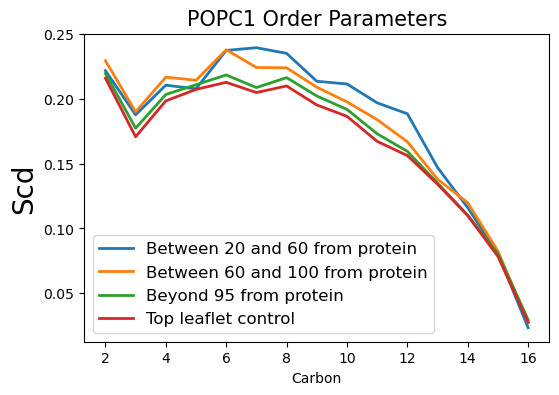

In [13]:
# Folder where the data files are located
folder_name = 'dcd_big'

# Create a new figure
fig, ax = plt.subplots(figsize=(6, 4))

# The files to be plotted
filenames = [f'{folder_name}/POPC1_bottom_big_20_60nm.dat', 
             f'{folder_name}/POPC1_bottom_big_60_90nm.dat', 
             f'POPC1_bottom_big_90nm.dat',
             f'{folder_name}/POPC1_top_big_control.dat']

labels = ['Between 20 and 60 from protein', 
          'Between 60 and 100 from protein', 
          'Beyond 95 from protein',
          'Top leaflet control']

# Load and plot the data
load_and_plot(ax, filenames, labels, 'POPC1 Order Parameters')

# plt.savefig('op_ranges.png', dpi=300)
plt.show()
